<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>
<img src="https://github.com/LinkedEarth/Logos/blob/master/LinkedEarth_medium.png?raw=true" width=500 alt="LinkedEarth Logo"></img>

# Investigating interhemispheric precipitation changes over the past millennium

---

## Overview

This CookBook demonstrates how to compare paleoclimate model output and proxy observations using EOF to identify large-scale spatio-temporal patterns in the data. It is inspired from a study by [Steinman et al. (2022)](https://www.pnas.org/doi/full/10.1073/pnas.2120015119) although it reuses different datasets.  

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Necessary | |
| [Using xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | Familiarity with understanding opening multiple files and merging |
|EOF (PCA) Analysis - See Chapter 12 of [this book](https://figshare.com/articles/book/Data_Analysis_in_the_Earth_Environmental_Sciences/1014336)|Helpful|Familiarity with the concepts is helpful for interpretation of the results|
|[Using Pyleoclim for Paleoclimate Data](http://linked.earth/PyleoTutorials/intro.html)|Helpful||
|[SPARQL](https://www.w3.org/TR/sparql11-query/)|Familiarity|Query language for graph database|

- **Time to learn**: 30 min.

---

## Imports

In [161]:
#To deal with model data
import s3fs
import fsspec
import xarray as xr
import glob

#To deal with proxy data
import pandas as pd
import numpy as np
import json
import requests
import pandas as pd
import io
import ast

#To deal with analysis
import pyleoclim as pyleo
from eofs.xarray import Eof

#Plotting and mapping
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import nc_time_axis

## PCA analysis on the CESM Last Millennium Analysis

The first step is the calculate precipitation $\delta^{18}O$ for the all forcing simulations. The following section demonstrates how to get the data from JetStream2 and pre-process each file to save the needed variable and place them into a new `xarray.Dataset`. This process can be time-consuming. 

### Get the CESM Last Millennium Ensemble data from JetStream2

Let's open the needed files for this analysis, which consists of various precipitation isotopes. All data have been made available on NSF JetStream2.

In [2]:
URL = 'https://js2.jetstream-cloud.org:8001/' #Locate and read a file

In [3]:
path = f'pythia/cesmLME' # specify data location

In [4]:
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL)) 
pattern = f's3://{path}/*.nc'
files = sorted(fs.glob(pattern))

Let's open relevant files for the all forcing simulations ('LME.002') for the 850-1850 period:

In [5]:
base_name = 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.'
time_period =  '085001-184912'

names = [name for name in files if base_name in name and time_period in name]

names

['pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRC_H216Or.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRC_H218Or.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRL_H216OR.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECRL_H218OR.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSC_H216Os.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSC_H218Os.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSL_H216OS.085001-184912.nc',
 'pythia/cesmLME/b.ie12.B1850C5CN.f19_g16.LME.002.cam.h0.PRECSL_H218OS.085001-184912.nc']

In [6]:
fileset = [fs.open(file) for file in names]

Next, let's open these datasets and extract the needed variables into another `xarray.Dataset`. 

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Note that this cell may take some time to run!
</div>

In [7]:
%%time
for idx,item in enumerate(fileset):
    ds_u = xr.open_dataset(item)
    var_name = names[idx].split('.')[-3]
    da = ds_u[var_name]
    try:
        ds[var_name]= da
    except:
        ds = da.to_dataset()
        ds.attrs = ds_u.attrs 
    ds_u.close()
    da.close()

CPU times: user 32.4 s, sys: 15.8 s, total: 48.2 s
Wall time: 6min 19s


And we're done! Let's have a look at the data we will be working with:

In [8]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:        (lat: 96, lon: 144, time: 12000)
Coordinates:
  * lat            (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon            (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time           (time) object 96kB 0850-02-01 00:00:00 ... 1850-01-01 00:0...
Data variables:
    PRECRC_H216Or  (time, lat, lon) float32 664MB ...
    PRECRC_H218Or  (time, lat, lon) float32 664MB ...
    PRECRL_H216OR  (time, lat, lon) float32 664MB ...
    PRECRL_H218OR  (time, lat, lon) float32 664MB ...
    PRECSC_H216Os  (time, lat, lon) float32 664MB ...
    PRECSC_H218Os  (time, lat, lon) float32 664MB ...
    PRECSL_H216OS  (time, lat, lon) float32 664MB ...
    PRECSL_H218OS  (time, lat, lon) float32 664MB ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.ie12.B1850C5CN.f19_g16.LME.002
    title:            UNSET
    logname:          tomas
    host:             r1i0n5
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850CN.f19_g16.850cntl.001.cam.i.0850-01-01-000...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/consisten...

### Select the tropical Central and South America region

Let's look at the region bounded by 27°S-27°N and 70°W-150°W:

In [9]:
ds_geo = ds.sel(lat=slice(-27,27), lon=slice(250,330))

Since the loading and pre-processing of the files take a long time, let's save a version of this dataset in netCDF for further use:

In [120]:
#ds_geo.to_netcdf(path='../data/LME.002.cam.h0.precip_iso.085001-184912.nc')

### Calculate Precipitation $\delta^{18}$O

In [10]:
%%time
p16O = ds_geo['PRECRC_H216Or'] + ds_geo['PRECSC_H216Os'] + ds_geo['PRECRL_H216OR'] + ds_geo['PRECSL_H216OS']
p18O = ds_geo['PRECRC_H218Or'] + ds_geo['PRECSC_H218Os'] + ds_geo['PRECRL_H218OR'] + ds_geo['PRECSL_H218OS']

p16O = p16O.where(p16O > 1e-18, 1e-18)
p18O = p18O.where(p18O > 1e-18, 1e-18)

d18Op = (p18O / p16O - 1)*1000

CPU times: user 59.8 s, sys: 17.8 s, total: 1min 17s
Wall time: 7min 1s


### Run PCA analysis

Let's first standardize the data: 

In [171]:
d18Oa = (d18Op - d18Op.mean(dim='time'))/d18Op.std(dim='time')

Create an EOF solver to do the EOF analysis.

In [172]:
solver = Eof(d18Oa, weights=None)

Retrieve the leading EOF, expressed as the covariance between the leading PC time series and the input d18O anomalies at each grid point.

In [173]:
eof1 = solver.eofsAsCovariance(neofs=3)

Plot the leading EOF expressed covariance

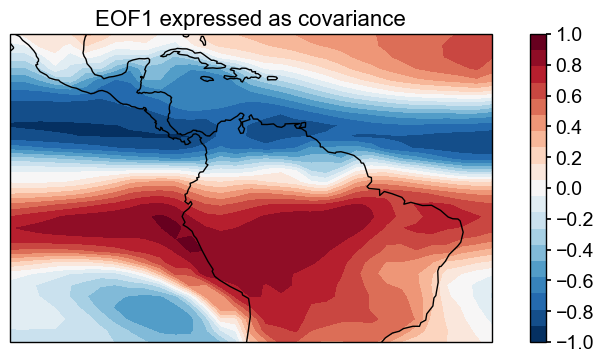

In [176]:
clevs = np.linspace(-1, 1, 20)
proj = ccrs.PlateCarree(central_longitude=290)
fig, ax = plt.subplots(figsize=[10,4], subplot_kw=dict(projection=proj))
ax.coastlines()
eof1[0].plot.contourf(ax=ax, levels = clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
fig.axes[1].set_ylabel('')
fig.axes[1].set_yticks(np.arange(-1,1.2,0.2))
ax.set_title('EOF1 expressed as covariance', fontsize=16)
plt.show()

Let's have a look at the first three PCs:

In [19]:
pcs = solver.pcs(npcs=3, pcscaling=1)

Text(0.5, 1.0, 'PC1 Time Series')

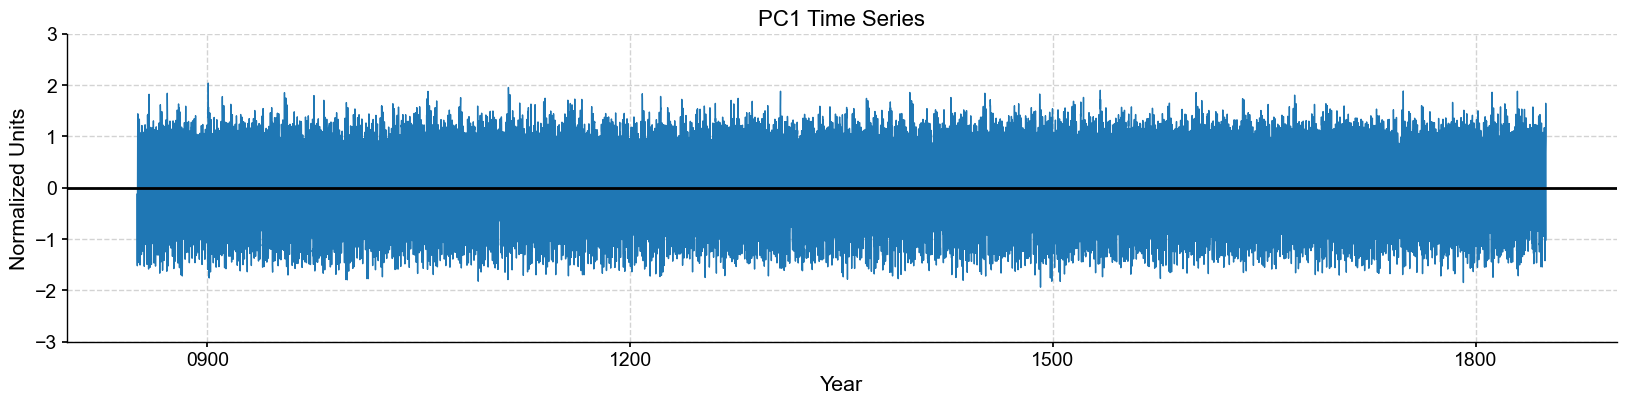

In [162]:
fig, ax = plt.subplots(figsize=[20,4])
pcs[:, 0].plot(ax=ax, linewidth=1)

ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

## PCA analysis on proxy observations

After looking at the model data, let's have a look at the proxy datasets.

### Query to remote database

The first step is the query the [LinkedEarth](https://linkedearth.graphdb.mint.isi.edu/) Graph Database for relevant datasets for comparison with the model. 

The database uses the SPARQL language for queries. We are filtering the database for the following criteria:
* Datasets bounded by 27°S-27°N and 70°W-150°W
* Datasets from the [Pages2k](https://lipdverse.org/project/pages2k/), [Iso2k](https://lipdverse.org/project/iso2k/), CoralHydro2k and SISAL working groups. These working groups identified archived datasets that were sensitive to temperature and the isotopic composition of precipication (precipitation $\delta{18}$O) and curated them for use in a standardized database.
* Timeseries within these datasets representing precipitation.

We asked for the following information back:
* The name of the dataset
* Geographical Location of the record expressed in latitude and longitude
* The type of archive (e.g., speleothem, Lake sediment) the measurements were made on
* The name of the variable
* The values and units of the measurements
* The time information (values and units) associated with the variable of interest.

The following cell points to the query API and creates the query itself.

In [73]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse-dynamic'

query = """PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT distinct?varID ?dataSetName ?lat ?lon ?varname ?interpLabel ?val ?varunits ?timevarname ?timeval ?timeunits ?archiveType where{

    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .
    OPTIONAL{?ds le:hasArchiveType ?archiveTypeObj .
             ?archiveTypeObj rdfs:label ?archiveType .}
    
    
    ?ds le:hasLocation ?loc .
    ?loc wgs84:lat ?lat .
    FILTER(?lat<26 && ?lat>-26) 
    ?loc wgs84:long ?lon .
    FILTER(?lon<-70 && ?lon>-150) 
    
    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .
    ?var le:hasName ?varname .
    VALUES ?varname {"d18O"} .
    ?var le:partOfCompilation  ?comp .
    ?comp le:hasName ?compName .
    VALUES ?compName {"iso2k" "Pages2kTemperature" "CoralHydro2k" "SISAL-LiPD"} .
    ?var le:hasInterpretation ?interp .
    ?interp le:hasVariable ?interpVar .
    ?interpVar rdfs:label ?interpLabel .
    FILTER (REGEX(?interpLabel, "precipitation.*", "i"))
    ?var le:hasVariableId ?varID .
    ?var le:hasValues ?val .
    OPTIONAL{?var le:hasUnits ?varunitsObj .
    		?varunitsObj rdfs:label ?varunits .}
    
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?timevarname .
    VALUES ?timevarname {"year" "age"} .
    ?timevar le:hasValues ?timeval .
    OPTIONAL{?timevar le:hasUnits ?timeunitsObj .
    		 ?timeunitsObj rdfs:label ?timeunits .}  
}"""

The following cell sends the query to the database and returns the results in a Pandas Dataframe.

In [179]:
response = requests.post(url, data = {'query': query})

data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

df['val']=df['val'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df['timeval']=df['timeval'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)

df.head()

,varID,dataSetName,lat,lon,varname,interpLabel,val,varunits,timevarname,timeval,timeunits,archiveType
0,TR04EVLI01,TR04EVLI,10.000,-85.000,d18O,precipitationIsotope,"[23.69, 24.29, 24.25, 24.74, 25.7, 26.33, 26.0...",permil,year,"[2000.75, 2000.73, 2000.72, 2000.71, 2000.7, 2...",yr AD,Wood
1,TR04EVLI01,TR04EVLI,10.000,-85.000,d18O,precipitation,"[23.69, 24.29, 24.25, 24.74, 25.7, 26.33, 26.0...",permil,year,"[2000.75, 2000.73, 2000.72, 2000.71, 2000.7, 2...",yr AD,Wood
2,SP09REPE01A,SP09REPE,-6.067,-77.183,d18O,precipitationIsotope,"[-6102.0, -6987.0, -6841.0, -7136.0, -6968.0, ...",permil,year,"[-198618, -2002417, -2001113, -1999809, -19985...",yr AD,Speleothem
3,SP09REPE01A,SP09REPE,-6.067,-77.183,d18O,precipitation,"[-6102.0, -6987.0, -6841.0, -7136.0, -6968.0, ...",permil,year,"[-198618, -2002417, -2001113, -1999809, -19985...",yr AD,Speleothem
4,SP09REPE02A,SP09REPE,-6.067,-77.183,d18O,precipitationIsotope,"[-6751.0, -6971.0, -6876.0, -6824.0, -6771.0, ...",permil,year,"[-1905513, -1903265, -1900455, -1897645, -1894...",yr AD,Speleothem


We have retrieved the following number of proxy records: 

In [118]:
len(df)

106

The first step is to make sure that everything is on the same representation of the time axis. Year is considered prograte while age is considered retrograde:

In [103]:
df['timevarname'].unique()

array(['year', 'age'], dtype=object)

Since we have records expressed in both year and age, let's convert everything to year. First let's have a look at the units:

In [104]:
df['timeunits'].unique()

array(['yr AD', 'yr BP'], dtype=object)

The units for age are expressed in BP (before present), if we assume the present to be 1950 by convention, then we can transform:

In [180]:
df['timeval'] = df['timeval'].apply(np.array)

def adjust_timeval(row):
    if row['timevarname'] == 'age':
        return 1950 - row['timeval']
    else:
        return row['timeval']

# Apply the function across the DataFrame rows
df['timeval'] = df.apply(adjust_timeval, axis=1)

It is obvious that some of the timeseries do not have correct time information (e.g., row 2). Let's filter the dataframe to make sure that the time values are within 0-2000 and that there is at least 1500 years of record:

In [181]:
def range_within_limits(array, lower = 0, upper = 2000, threshold = 1500):
    filtered_values = array[(array >= lower) & (array <= upper)]
    if filtered_values.size > 0:  # Check if there are any values within the range
        return np.ptp(filtered_values) >= threshold  # np.ptp() returns the range of values
    return False  # If no values within the range, filter out the row


# Apply the function to filter the DataFrame
filtered_df = df[df['timeval'].apply(range_within_limits)]

We are now left with:

In [182]:
len(filtered_df)

44

Let's also make sure that the records are long enough (i.e., more than 1500 years long):

In [183]:
def array_range_exceeds(array, threshold=1500):
    return np.max(array) - np.min(array) > threshold

filt_df = filtered_df[filtered_df['timeval'].apply(array_range_exceeds)]
filt_df.head()

,varID,dataSetName,lat,lon,varname,interpLabel,val,varunits,timevarname,timeval,timeunits,archiveType
12,IC95THHU02D,IC95THHU,-9.0000,-77.5000,d18O,precipitationIsotope,"[-17.38, -17.24, -18.3, -19.1, -19.34, -19.2, ...",permil,year,"[1950, 1850, 1750, 1650, 1550, 1450, 1350, 125...",yr AD,Glacier ice
13,SP13CHPE01A,SP13CHPE,-5.9300,-77.3000,d18O,precipitationIsotope,"[-7.17, -7.24, nan, -6.99, -7.15, -7.41, -7.31...",permil,year,"[1660, 1650, 1650, 1640, 1630, 1630, 1620, 161...",yr AD,Speleothem
14,SP13CHPE01A,SP13CHPE,-5.9300,-77.3000,d18O,"Precipitation_amount, SAM","[-7.17, -7.24, nan, -6.99, -7.15, -7.41, -7.31...",permil,year,"[1660, 1650, 1650, 1640, 1630, 1630, 1620, 161...",yr AD,Speleothem
17,SAm_035,IC13THQU,-13.9333,-70.8333,d18O,precipitationIsotope,"[-18.5905, -16.3244, -16.2324, -17.0112, -18.6...",permil,year,"[2009, 2008, 2007, 2006, 2005, 2004, 2003, 200...",yr AD,Glacier ice
20,SP08VBPE03A,SP08VBPE,-5.9400,-77.3100,d18O,precipitationIsotope,"[-6.09, -6.74, -6.37, -6.91, -6.57, nan, -5.64...",permil,year,"[1915, 513, 81, -911, -1405, -2192, -3477, -42...",yr AD,Speleothem


This leaves us with the following number of datasets:

In [184]:
len(filt_df)

34

Let's filter for records with a resolution of at least 60 years:

In [199]:
def min_resolution(array, min_res=60):
    if len(array) > 1:  # Ensure there are at least two points to calculate a difference
        # Calculate differences between consecutive elements
        differences = np.mean(np.diff(array))
        # Check if the minimum difference is at least 50
        return abs(differences) <= min_res
    return False  # If less than two elements, can't compute difference

# Apply the function and filter the DataFrame
filtered_df2 = filt_df[filt_df['timeval'].apply(min_resolution)]

This leaves us with the following number of datasets:

In [200]:
len(filtered_df2)

29

Next, let's use the [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) software package and create individual [GeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#geoseries-pyleoclim-geoseries) objects:

In [201]:
ts_list = []
for _, row in filtered_df2.iterrows():
        ts_list.append(pyleo.GeoSeries(time=row['timeval'],value=row['val'],
                                   time_name='year',value_name=row['varname'],
                                   time_unit='CE', value_unit=row['varunits'],
                                   lat = row['lat'], lon = row['lon'],
                                   archiveType = row['archiveType'], verbose = False, 
                                   label=row['dataSetName']+'_'+row['varname']))

        #print(row['timeval'])

Now let's use a [MultipleGeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#multiplegeoseries-pyleoclim-multiplegeoseries) object for visualization and analysis: 

In [202]:
mgs = pyleo.MultipleGeoSeries(ts_list, label='HydroAm2k', time_unit='year CE') 

Let's first map the location of the records by the type of archive:

(<Figure size 1600x600 with 3 Axes>,
 {'cb': <Axes: >,
  'map': <GeoAxes: xlabel='lon', ylabel='lat'>,
  'leg': <Axes: >})

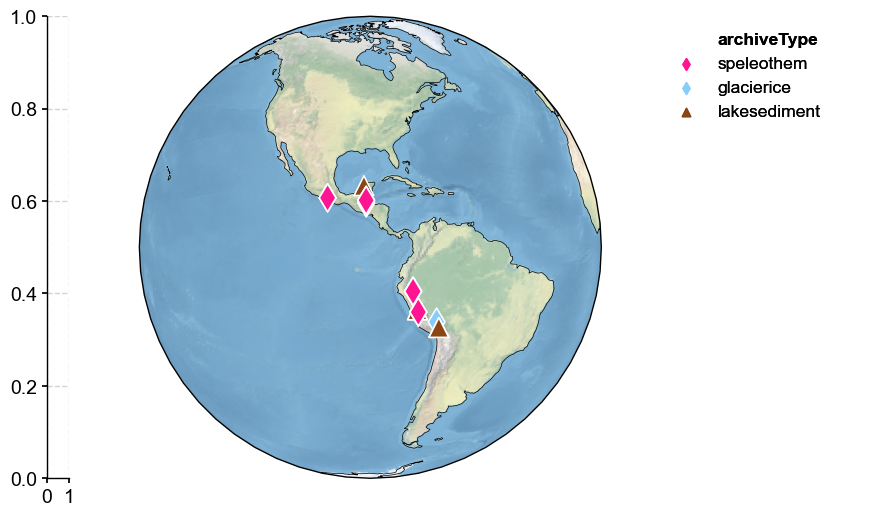

In [203]:
mgs.map()

Let's have a look at the records, sliced for the 0-2000 period

(<Figure size 640x480 with 30 Axes>,
 {0: <Axes: ylabel='d18O [permil]'>,
  1: <Axes: ylabel='d18O [permil]'>,
  2: <Axes: ylabel='d18O [permil]'>,
  3: <Axes: ylabel='d18O [permil]'>,
  4: <Axes: ylabel='d18O [permil]'>,
  5: <Axes: ylabel='d18O [permil]'>,
  6: <Axes: ylabel='d18O [permil]'>,
  7: <Axes: ylabel='d18O [permil]'>,
  8: <Axes: ylabel='d18O [permil]'>,
  9: <Axes: ylabel='d18O [permil]'>,
  10: <Axes: ylabel='d18O [permil]'>,
  11: <Axes: ylabel='d18O [permil]'>,
  12: <Axes: ylabel='d18O [permil]'>,
  13: <Axes: ylabel='d18O [permil]'>,
  14: <Axes: ylabel='d18O [permil]'>,
  15: <Axes: ylabel='d18O [permil]'>,
  16: <Axes: ylabel='d18O [permil]'>,
  17: <Axes: ylabel='d18O [permil]'>,
  18: <Axes: ylabel='d18O [permil]'>,
  19: <Axes: ylabel='d18O [permil]'>,
  20: <Axes: ylabel='d18O [permil]'>,
  21: <Axes: ylabel='d18O [permil]'>,
  22: <Axes: ylabel='d18O [permil]'>,
  23: <Axes: ylabel='d18O [permil]'>,
  24: <Axes: ylabel='d18O [permil]'>,
  25: <Axes: ylabel='d1

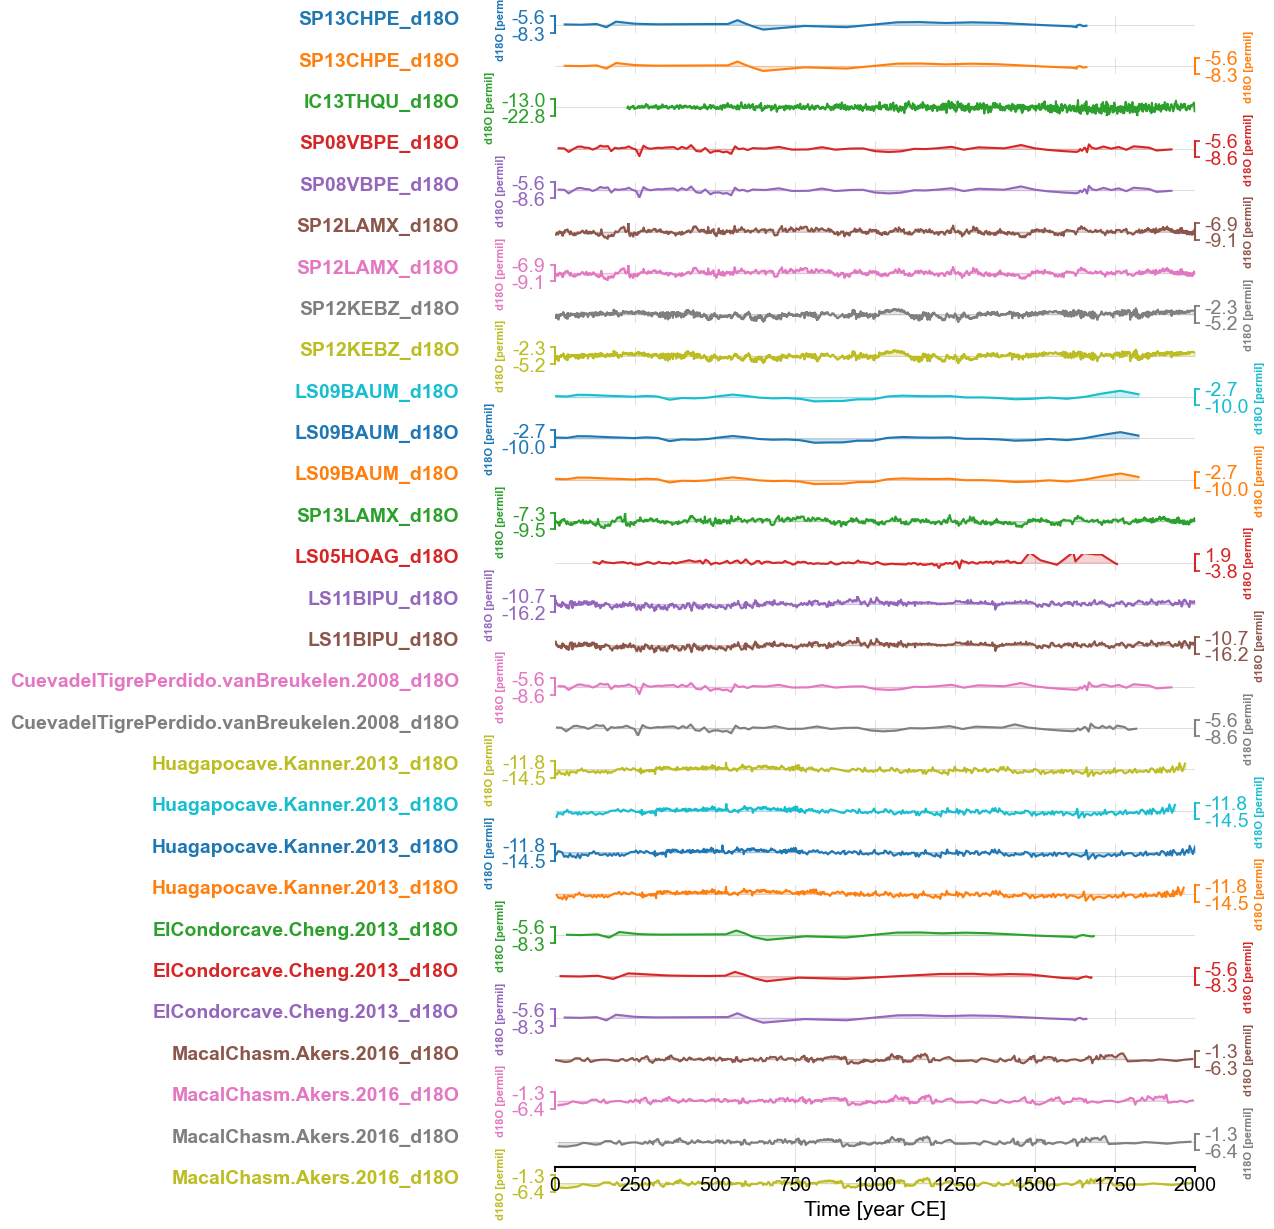

In [212]:
mgs.sel(time=slice(0,2000)).stackplot(v_shift_factor=2.5)

### Run PCA Analysis

Let's place them on a common time axis for analysis and standardize:

In [205]:
mgs_common = mgs.common_time().standardize()

In [206]:
pca = mgs_common.pca()

Let's have a look at the screeplot:

The provided eigenvalue array has only one dimension. UQ defaults to NB82


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'HydroAm2k PCA eigenvalues'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

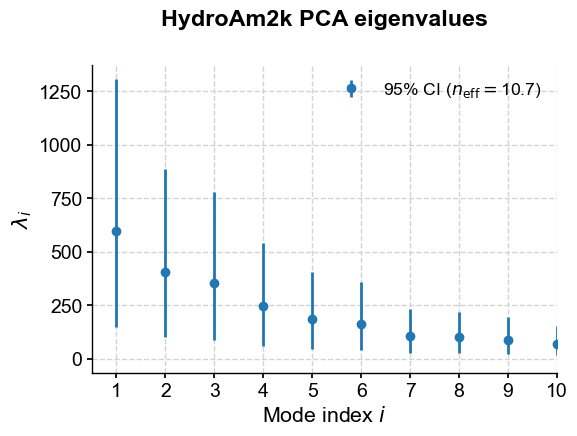

In [207]:
pca.screeplot()

As is nearly always the case with geophysical timeseries, the first few of eigenvalues trully overwhelm the rest. In this case, let's have a look at the first three.  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year CE]', ylabel='$PC_1$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

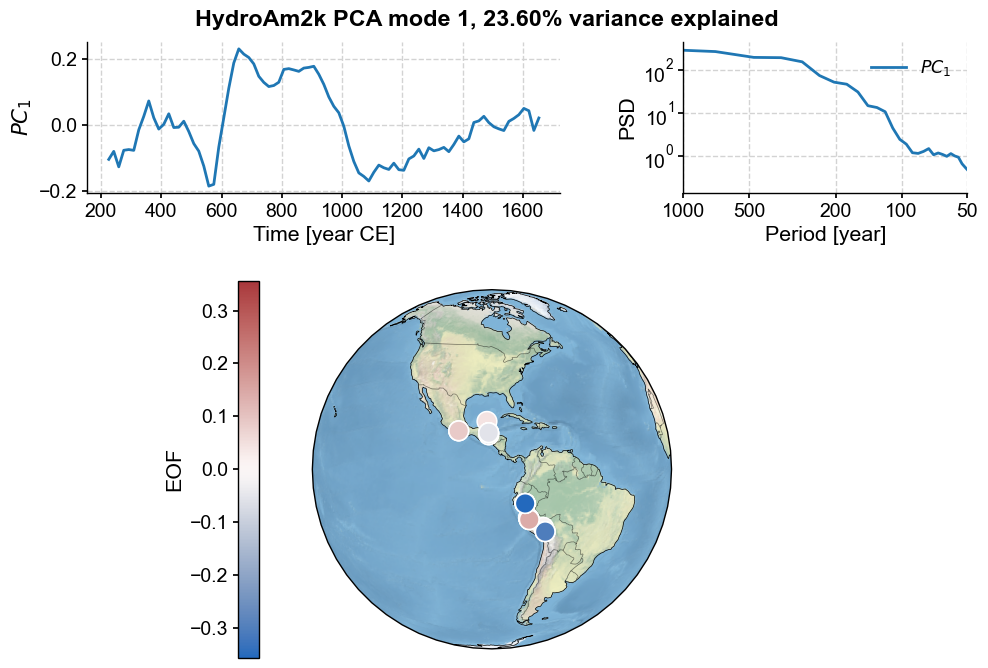

In [208]:
pca.modeplot()

Let's have a look at the second mode: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year CE]', ylabel='$PC_2$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

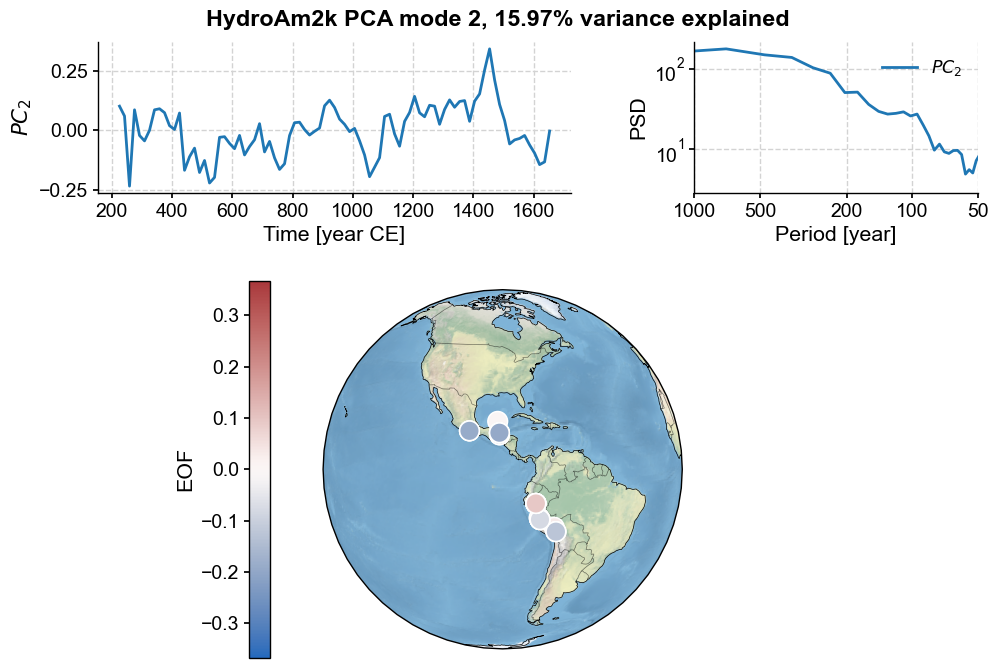

In [209]:
pca.modeplot(index=1)

Finally, let's have a look at the third mode:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year CE]', ylabel='$PC_3$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

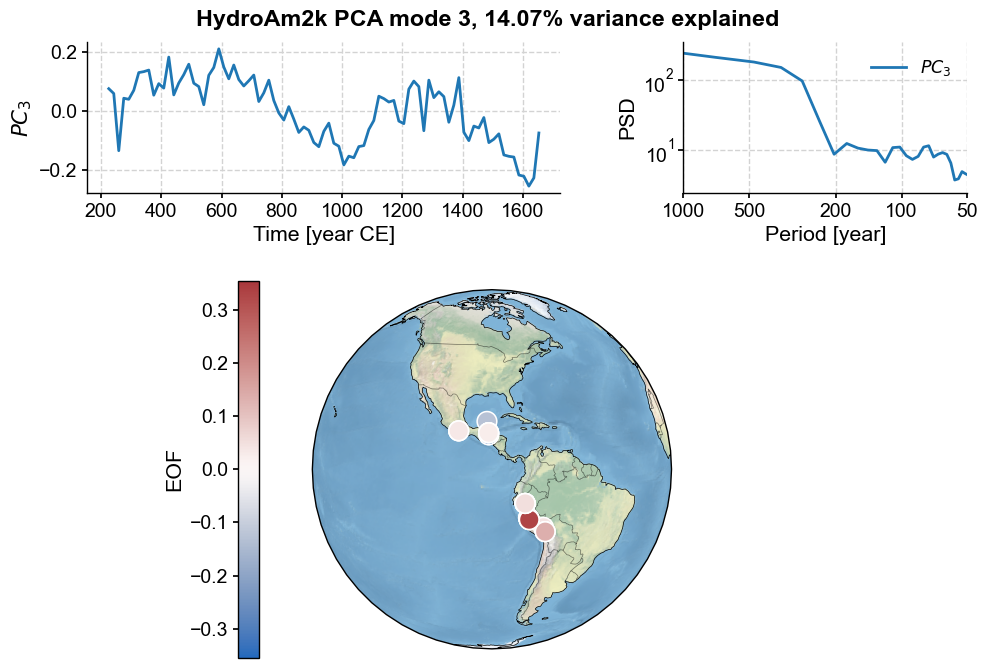

In [210]:
pca.modeplot(index=2)

As you can see, the first three modes explain 63% of the variance.

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!